In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from timeit import default_timer as timer
import html

from fastai.text import *

In [3]:
BOS = 'xbos'    #beginning of sentence tag, useful for model to know this
FLD = 'xfld'    #data field tag

PATH=Path('..')/'data/imdb/aclImdb'

In [4]:
os.listdir(PATH)

['test', 'imdbEr.txt', 'models', 'imdb.vocab', 'README', 'train', 'tmp']

## Standardize format

In [5]:
#Classifier
CLAS_PATH=Path('..')/'data/imdb/imdb_clas'
CLAS_PATH.mkdir(exist_ok=True)

#Language Model
LM_PATH=Path('..')/'data/imdb/imdb_lm'
LM_PATH.mkdir(exist_ok=True)

In [6]:
#unsup for unlabelled
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        #The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
        for fname in (path/label).glob('*.*'):
            #eg ../data/imdb/aclImdb/train/neg/1696_1.txt
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts), np.array(labels)

trn_texts, trn_labels = get_texts(PATH/'train')
val_texts, val_labels = get_texts(PATH/'test')

In [7]:
print(f'len(trn_texts): {len(trn_texts)}, len(val_texts): {len(val_texts)}')

len(trn_texts): 75000, len(val_texts): 25000


In [8]:
col_names = ['labels', 'text']

In [9]:
#make randomness reproducible
np.random.seed(42)
#randomly shuffle this list
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [10]:
#create our randomly sorted training and validation lists-generally a good idea to do this
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [11]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [12]:
#for training data, remove unsupervised
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv',header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

#write the classes to a file ie neg pos unsup
(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}/n' for o in CLASSES)

#### Language Model

In [13]:
#use more data for training than the given split
trn_texts,val_texts = sklearn.model_selection.train_test_split(np.concatenate([trn_texts, val_texts]), test_size=0.1)

In [14]:
len(trn_texts), len(val_texts)

(90000, 10000)

In [15]:
#initialise classifications to zero
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

In [16]:
df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language Model Tokens

Turn text into a a list of tokens using Spacy

In [17]:
#this makes pandas more efficient-when passed in to pandas, returns an iterator to iterate through chinks, then loop through these chinks of the dataframe
CHUNKSIZE = 24000

In [18]:
#Compile a regular expression pattern, returning a pattern object
re1 = re.compile(r'  +')

#this may not catch all badly formatted text, may need to add to/modify for other input datasets
def fixup(text_str):
    text_str = text_str.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(text_str))

In [19]:
print(f'max thread count: {len(os.sched_getaffinity(0))}')

max thread count: 16


In [20]:
def get_texts(df, n_lbls=1):
    #.iloc[<row_selection>,<col_selction>] here default is column 0 only
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 '+ df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)):
        texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    #type(texts): <class 'pandas.core.series.Series'>
    #uses ProcessPoolExcutor with 1/2 of the cpu's, pass in a series to tokenize
    start = timer()
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    end = timer()
    print(f'elapsed: {end - start}')
    return tok, list(labels)

In [21]:
def get_all(tf_reader, n_lbls):
    #iterate over the TextFileReader object in chunks
    tok, labels = [], []
    for i, r in enumerate(tf_reader):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_
        labels += labels_
    return tok, labels

In [22]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=CHUNKSIZE)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=CHUNKSIZE)
#note is not a dataframe
print(f'type(df_trn): {type(df_trn)}')

type(df_trn): <class 'pandas.io.parsers.TextFileReader'>


In [23]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
elapsed: 10.890161111999987
1
elapsed: 10.787831979000032
2
elapsed: 12.000589405000028
3
elapsed: 9.582720452000046
0
elapsed: 6.9983108370000195


In [24]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [25]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [26]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1208720),
 ('.', 992289),
 (',', 985894),
 ('and', 587669),
 ('a', 583416),
 ('of', 524547),
 ('to', 485444),
 ('is', 393719),
 ('it', 341529),
 ('in', 337479),
 ('i', 308765),
 ('this', 270621),
 ('that', 261325),
 ('"', 237987),
 ("'s", 221352),
 ('-', 188458),
 ('was', 180575),
 ('\n\n', 179252),
 ('as', 165832),
 ('with', 159371),
 ('for', 159029),
 ('movie', 158056),
 ('but', 150514),
 ('film', 144268),
 ('you', 124349)]

In [27]:
#limit as over this code gets 'clunky'
MAX_VOCAB = 60000
MIN_FREQ = 2

itos: index to string
stoi: string to index

In [28]:
#index those tokens that appear more than 2x
itos = [o for o,c in freq.most_common(MAX_VOCAB) if c>MIN_FREQ]
itos.insert(0, '_pad_')
#use if not in vocab
itos.insert(0, '_unk_')
itos[2]

'the'

In [29]:
#default to 0 if not in dict
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(stoi)

60002

In [30]:
#index each token for each review
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])
trn_lm.shape

(90000,)

In [31]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl','wb'))

In [32]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [33]:
VOCAB_SIZE = len(itos)
VOCAB_SIZE, len(trn_lm)

(60002, 90000)

## wikitext103 Conversion

pre-trained on a wikipedia subset


In [34]:
# ! wget -nH -r -np http://files.fast.ai/models/wt103/

In [35]:
EMBEDDING_SIZE = 400

In [36]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [37]:
#torch.load uses Python's unpickling facilities but treats storages, which underlie tensors, specially
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [38]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [39]:
row_m

array([-0.0183 , -0.13826,  0.01438, -0.01285,  0.00407,  0.01944,  0.01149, -0.13282, -0.02295, -0.01722,
        0.02994,  0.00921,  0.00077,  0.00438,  0.00857, -0.02888, -0.00394,  0.0118 ,  0.00879,  0.01494,
       -0.00642, -0.00382,  0.00579, -0.03775,  0.03073, -0.07047, -0.07171,  0.0123 , -0.00541,  0.1581 ,
        0.01737, -0.00911, -0.01698, -0.01113,  0.05755,  0.00127,  0.00395,  0.00114,  0.01878,  0.071  ,
        0.01962, -0.00169, -0.00555, -0.00386, -0.01911, -0.01806,  0.00647,  0.10169,  0.09787,  0.01921,
        0.03101,  0.00116,  0.02322, -0.00719, -0.01492, -0.04923, -0.01528, -0.00084,  0.02119,  0.01153,
       -0.00317, -0.0043 ,  0.00564,  0.00659, -0.00396, -0.01103, -0.0344 , -0.02405,  0.003  , -0.00386,
       -0.1157 , -0.02246,  0.00273,  0.01854, -0.10246,  0.0069 ,  0.0072 ,  0.12784,  0.01825, -0.00071,
       -0.02564, -0.01285, -0.06124,  0.05601, -0.00821,  0.12663,  0.00022,  0.00273,  0.02539,  0.00257,
        0.01811, -0.01827, -0.01772, 

In [40]:
itos_wiki = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi_wiki = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos_wiki)})

In [41]:
#we need to map our itos to itos for wikitext
new_wgts = np.zeros((VOCAB_SIZE, EMBEDDING_SIZE), dtype=np.float32)
for i, w in enumerate(itos):
    r = stoi_wiki[w]
    #use mean if our string doesnt exist in wiki
    new_wgts[i] = enc_wgts[r] if r>=0 else row_m
    

In [42]:
#T: convert to torch tensor and put on gpu
wgts['0.encoder.weight'] = T(new_wgts)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_wgts))
#decoder uses same weights
wgts['1.decoder.weight'] = T(np.copy(new_wgts))

## Language Model

In [43]:
#number of hidden activation per LSTM layer
n_hid= 1150
#number of LSTM layers to use in the architecture
n_layers = 3
wd=1e-7
#grab 70 at a time
bptt=70
bs=52

In [44]:
#betas (Tuple[float, float], optional): coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
#for nlp better to use the defaults below
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [45]:
#when we iterate over LanguageModelLoader, the sequence length is changed with a normal distribution and significantly changed 5% of time
#on first iteration: seq_len = bptt+5*5 ie 95 here
#subseqently: seq_len = max(5, int(np.random.normal(bptt, 5))) where 5% of time the mean bptt=bptt/2
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)

#LanguageModelData returns a RNN_Learner with SequentialRNN model
#(The SequentialRNN layer is the native torch's Sequential wrapper that puts the RNN_Encoder and LinearDecoder layers sequentially in the model.)
model_data = LanguageModelData(PATH, pad_idx=1, nt=VOCAB_SIZE, trn_dl=trn_dl, val_dl=val_dl, bs=bs, bptt=bptt)

In [46]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [47]:
#dropout: dropout to apply to the activations going from one LSTM layer to another
#dropouti (float): dropout to apply to the input layer.
#wdrop (float): dropout used for a LSTM's internal (or hidden) recurrent weights.
#dropoute (float): dropout to apply to the embedding layer.
#dropouth (float): dropout to apply to the activations going from one LSTM layer to another
kwargs = {'dropouti': drops[0], 'dropout': drops[1], 'wdrop': drops[2], 'dropoute': drops[3], 'dropouth': drops[4]}

#returns a RNN_Learner with model ~ SequentialRNN(RNN_Encoder(...), LinearDecoder(...))
learner = model_data.get_model(opt_fn = opt_fn, emb_sz = EMBEDDING_SIZE, n_hid = n_hid, n_layers = n_layers, **kwargs)

In [48]:
learner.metrics = [accuracy]
learner.unfreeze

<bound method Learner.unfreeze of SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)>

In [49]:
lr=1e-3
lrs=lr

In [50]:
#start = timer()
#learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)
#end = timer()
#print(f'elapsed: {end - start}')
#showing seq_len and bptt values:
# 0%|          | 0/6870 [00:00<?, ?it/s]initial seq_len: 95, bptt: 70
# 0%|          | 1/6870 [00:01<2:29:15,  1.30s/it, loss=11]seq_len: 36, bptt: 70
# 0%|          | 2/6870 [00:01<1:20:31,  1.42it/s, loss=11]seq_len: 73, bptt: 70
# 0%|          | 3/6870 [00:01<1:00:29,  1.89it/s, loss=11]seq_len: 73, bptt: 70
# 0%|          | 4/6870 [00:01<50:36,  2.26it/s, loss=11]  seq_len: 65, bptt: 70

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      4.923311   4.85077    0.227321  

elapsed: 1218.5052418339983


In [51]:
#learner.save('lm_last_fit')

In [50]:
learner.load('lm_last_fit')

In [51]:
learner.unfreeze()

In [52]:
start = timer()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)
end = timer()
print(f'elapsed: {end - start}')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      4.909408   4.782053   0.228918  



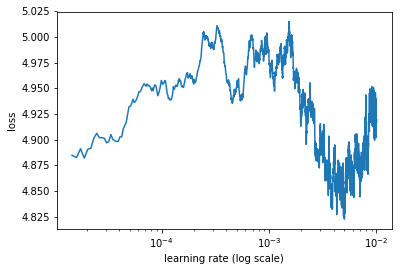

In [53]:
learner.sched.plot()

In [54]:
start = timer()
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)
end = timer()
print(f'elapsed: {end - start}')

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      4.702503   4.600949   0.24712   
    1      4.482495   4.388694   0.265958  
    2      4.37841    4.286706   0.276195  
    3      4.318969   4.230582   0.281842  
    4      4.271356   4.197506   0.285195  
    5      4.236107   4.168468   0.288274  
    6      4.208029   4.150225   0.290535  
    7      4.217725   4.132238   0.291919  
    8      4.161472   4.119818   0.293469  
    9      4.135765   4.109227   0.294754  
    10     4.13842    4.099373   0.295985  
    11     4.155049   4.085883   0.297143  
    12     4.130206   4.081128   0.297931  
    13     4.090393   4.075789   0.298719  
    14     4.045284   4.072163   0.299391  

elapsed: 18339.458027785


In [ ]:
#5 hours on a GTX1080Ti !

In [55]:
learner.save('lm1')

In [56]:
learner.save_encoder('lm1_enc')

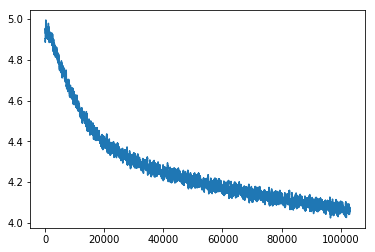

In [57]:
learner.sched.plot_loss()

## Classifier Tokens

In [58]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=CHUNKSIZE)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=CHUNKSIZE)

In [59]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=CHUNKSIZE)

In [60]:
tok_trn, trn_labels = get_all(tf_reader=df_trn, n_lbls=1)
tok_val, val_labels = get_all(tf_reader=df_trn, n_lbls=1)

0
elapsed: 13.197475705001125
1
elapsed: 3.8370880160000524


In [61]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [ ]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [ ]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

In [ ]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier